# Figure 6D & S4 

# Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from sympy import symbols, solve, simplify
import seaborn as sb
import pandas as pd
from scipy.optimize import curve_fit
import sympy as sp
plt.rcParams.update({'font.size': 20})

# Definitions

Functions to fit and plot a curve with an Hill function:

In [2]:
def model_piu(x, a, b, c):
    return c*x**a/(x**a+b**a) 

def Hill_fit_piu(z,x,model, bo):
    y= z-min(z)
    yR= y/max(y)
    popt, _ = curve_fit(model, x, yR, bounds=bo)
    a,b,c = popt  
    return [round(a,8), round(b,8), round(c,8)]

Heatmap

In [3]:
def myHeatmap(data, Min, Max, axs): 
    sb.heatmap(data,cmap='inferno',vmin=Min, vmax=Max, cbar=False, ax=axs, xticklabels=False,yticklabels=False)

# Model 

Definition of the parameters of the model

In [4]:
T, V1, V2, K1, K2, Kb = symbols('T V1 V2 K1 K2 Kb') 
Vs, Rb, Ks, Vrg, Qb, Krg = symbols('Vs Rb Ks Vrg Qb Krg')
R, F, Kd, Q, E, Ke = symbols('R F Kd Q E Ke')
S1, Qtot, S2, Rtot= symbols('S1 Qtot S2 Rtot')
Ap,kMM3,Er,KMM3,vMM4,KMM4 = symbols('Ap kMM3 Er KMM3 vMM4 KMM4')
I, kMM1, Er, KMM1, vMM2,KMM2 = symbols('I kMM1 Er KMM1 vMM2 KMM2')
vb, vo, Ap, Ka, Ki, I, k, O = symbols('vb vo Ap Ka Ki I k O')

Evolution equation for T

In [5]:
# Evolution equation for T: 
expr = V1*(1-T)/(K1+(1-T))-V2*T/(K2+T)-Kb*T
expr_simplified= V1*(1-T)*(K2+T) -V2*T*(K1+(1-T))-Kb*T*(K1+(1-T))*(K2+T)
print('Evolution equation for T:')
print(expr)

# Substitute the expression for V1 and V2 in the evolution equation for T:  
expr_RQ= expr_simplified.subs([(V1, Vs*(R*F/(Kd+F))/(Ks+(R*F/(Kd+F)))),(V2, Vrg*(Q*E/(Ke+E))/(Krg+(Q*E/(Ke+E))))])

# Substitute the expressions for Q and R
expr_S1S2 = expr_RQ.subs([(R, Rtot*S1),(Q, Qtot*S2)])

# Expliciting the relation between S1 and S2 to obtain T(FGF, S1): 
expr_T = expr_S1S2.subs([(S2,-1.1265*S1 +0.9092)])

print('Evolution equation for T (all parameters explicited):')
print(expr_T)

# Solve the equation 
sol = solve(expr_T, T)[2]

Evolution equation for T:
-Kb*T - T*V2/(K2 + T) + V1*(1 - T)/(K1 - T + 1)
Evolution equation for T (all parameters explicited):
-E*Qtot*T*Vrg*(0.9092 - 1.1265*S1)*(K1 - T + 1)/((E + Ke)*(E*Qtot*(0.9092 - 1.1265*S1)/(E + Ke) + Krg)) + F*Rtot*S1*Vs*(1 - T)*(K2 + T)/((F + Kd)*(F*Rtot*S1/(F + Kd) + Ks)) - Kb*T*(K2 + T)*(K1 - T + 1)


Definition of the function ExprT that compute T as a function of all the parameters of the equation

In [6]:
def exprT(Vs_v=1, Vrg_v=0.4, K1_v=0.5, K2_v=0.2, Krg_v=1200, Ks_v=1200, Kb_v=0.2, F_v=5, Kd_v=25, E_v=5, Ke_v=50, Rtot_v=2000, Qtot_v=2000, S1_v=0.5):
    sol_T = sol.subs([(Vs,Vs_v),(Vrg,Vrg_v),(K1, K1_v),(K2,K2_v),(Krg, Krg_v), (Ks, Ks_v), (Kb, Kb_v),(F, F_v),(Kd, Kd_v),(E,E_v), (Ke, Ke_v),(Rtot, Rtot_v),(Qtot,Qtot_v),(S1,S1_v)])
    sol_T = np.real(np.array(sol_T,complex))
    return sol_T

In [7]:
# Solve the equation 
sol_S1S2 = solve(expr_S1S2, T)[1]

def exprT_S1S2(Vs_v=1, Vrg_v=0.4, K1_v=0.5, K2_v=0.2, Krg_v=1200, Ks_v=1200, Kb_v=0.2, F_v=5, Kd_v=25, E_v=5, Ke_v=50, Rtot_v=2000, Qtot_v=2000, S1_v=0.5, S2_v= 0.4):
    sol_S= sol_S1S2.subs([(Vs,Vs_v),(Vrg,Vrg_v),(K1, K1_v),(K2,K2_v),(Krg, Krg_v), (Ks, Ks_v), (Kb, Kb_v),(F, F_v),(Kd, Kd_v),(E,E_v), (Ke, Ke_v),(Rtot, Rtot_v),(Qtot,Qtot_v),(S1,S1_v),(S2,S2_v)])
    sol_S = np.real(np.array(sol_S,complex))
    return sol_S

Definition of the function to compute Erk (as a function of T)

In [8]:
def Erk(T,n=2, Kerk=0.5, Erk_max=1, Erk_bas=0): 
    Erk = [ Erk_max* T[i]**n/(T[i]**n +Kerk**n)+Erk_bas for i in range(len(T)) ]
    return Erk

Evolution equation for the activator Ap

In [9]:
expr_Ap = kMM3*Er*(1-Ap)/(KMM3+(1-Ap))-vMM4*Ap/(KMM4+Ap)
sol_Ap= solve(expr_Ap, Ap)[1] 

# Function to compute Ap as a function of the other parameters:  
def exprAp(kMM3_v=12,Er_v=0.5,KMM3_v=0.05,vMM4_v=1,KMM4_v=0.05):
    solAp= sol_Ap.subs([(kMM3,kMM3_v), (Er,Er_v), (KMM4,KMM4_v), (vMM4,vMM4_v), (KMM3,KMM3_v)]) 
    return solAp

Evolution equation for the inhibitor I

In [10]:
expr_I = -kMM1*Er*I/(KMM1+I)+vMM2*(1-I)/(KMM2+(1-I))
sol_I= solve(expr_I, I)[0] 

# Function to compute I as a function of the other parameters: 
def exprI(kMM1_v=12,Er_v=0.5,KMM1_v=0.05,vMM2_v=1,KMM2_v=0.05): 
    solI= sol_I.subs([(kMM1,kMM1_v), (Er,Er_v), (KMM1,KMM1_v), (vMM2,vMM2_v), (KMM2,KMM2_v)]) 
    return solI 

Compute Otx and define a function ExprOtx that compute Otx as a function of all the parameters of the equation

In [11]:
expr_Otx = vb+ vo*Ap/((Ka*(1+I/Ki))+Ap)-k*O
sol_Otx= solve(expr_Otx, O)[0]  

# Function to compute Otx as a function of the other parameters
def exprOtx1(Ap_v, I_v, vb_v=0.001,vo_v=1,Ka_v=0.1,Ki_v=0.1,k_v=0.2, Omax=1, Obas=0): 
    solOtx= sol_Otx.subs([(Ap, Ap_v), (I, I_v), (vb,vb_v), (vo,vo_v), (Ka,Ka_v), (Ki,Ki_v), (k,k_v)])*Omax +Obas 
    #solOtx= [sol_Otx.subs([(Ap, Ap_v[i]), (I, I_v[i]), (vb,vb_v), (vo,vo_v), (Ka,Ka_v), (Ki,Ki_v), (k,k_v)])*Omax +Obas for i in range(len(Ap_v))] 
    return solOtx

def exprOtx(Ap_v, I_v, vb_v=0.001,vo_v=1,Ka_v=0.1,Ki_v=0.1,k_v=0.2, Omax=1, Obas=0): 
    solOtx= [sol_Otx.subs([(Ap, Ap_v[i]), (I, I_v[i]), (vb,vb_v), (vo,vo_v), (Ka,Ka_v), (Ki,Ki_v), (k,k_v)])*Omax +Obas for i in range(len(Ap_v))] 
    return solOtx

# Results

## Figure 6D: upper panel

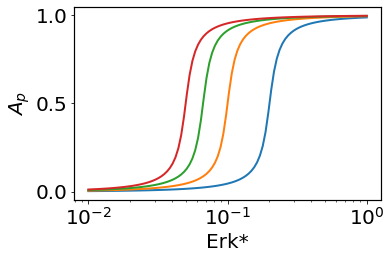

In [15]:
kMM3_value = [5, 10, 15, 20]
Erk_temp= np.logspace(-2,0, 100)

# Figure for Ap 
plt.figure(figsize=(6,4))
for j in range(len(kMM3_value)): 
    Ap_temp=[exprAp(Er_v=Erk_temp[i], kMM3_v= kMM3_value[j]) for i in range(len(Erk_temp))]
    plt.plot(Erk_temp, Ap_temp, linewidth=2)
    
plt.xlabel('Erk*')
plt.ylabel('$A_p$')
plt.xscale('log')

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.2)

plt.tight_layout()
plt.show()

## Figure 6D: heatmap

In [16]:
kMM1_value = np.linspace(5,30,51)
kMM3_value = np.linspace(5,30,51)

Erk_temp= np.logspace(-2,0)

nOpos_temp = np.zeros([len(kMM3_value), len(kMM1_value)])
nAp_temp = np.ones(len(kMM3_value))

for i in range(len(kMM3_value)):
    for j in range(len(kMM1_value)): 
        Ap_temp= np.array([exprAp(Er_v=Erk_temp[k], kMM3_v= kMM3_value[i]) for k in range(len(Erk_temp))])
        I_temp= np.array([exprI(Er_v=Erk_temp[k], kMM1_v= kMM1_value[j]) for k in range(len(Erk_temp))])
      
        Otx_temp = np.array(exprOtx(Ap_v= Ap_temp, I_v= I_temp))
        nOpos_temp[i,j] = Hill_fit_piu(Otx_temp, Erk_temp, model_piu, bo=((0,0,0),(100,1,10)))[0]

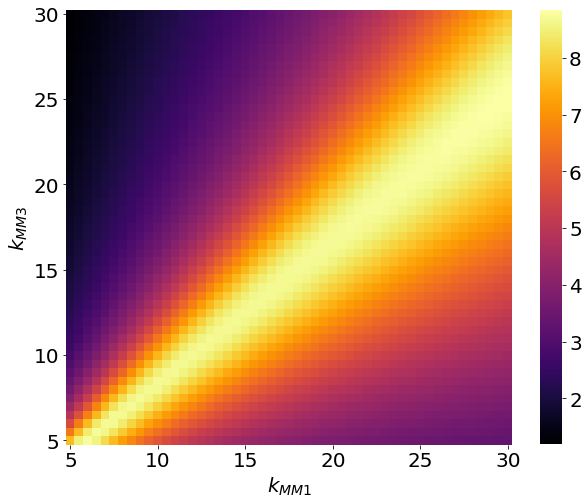

In [17]:
plt.figure(figsize=(10,8))
ax= sb.heatmap(nOpos_temp, cmap='inferno')
plt.xlabel('$k_{MM1}$')
plt.ylabel('$k_{MM3}$')
ax.invert_yaxis()
plt.xticks([0.5,10.5,20.5,30.5,40.5,50.5], ['5', '10', '15', '20', '25', '30'])
plt.yticks([0.5,10.5,20.5,30.5,40.5,50.5], ['5', '10', '15', '20', '25', '30'], rotation=360)
plt.show()

## Figure 4S: left panel

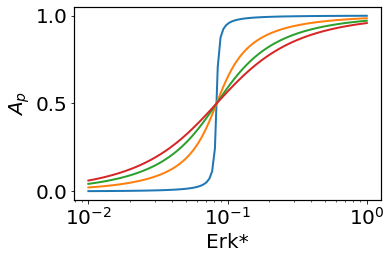

In [12]:
KMM3_value = [0.01, 0.2, 0.5, 1]
Erk_temp= np.logspace(-2,0, 100)

# Figure for Ap 
plt.figure(figsize=(6,4))
for j in range(len(KMM3_value)): 
    Ap_temp=[exprAp(Er_v=Erk_temp[i], KMM3_v= KMM3_value[j], KMM4_v= KMM3_value[j]) for i in range(len(Erk_temp))]
    plt.plot(Erk_temp, Ap_temp, linewidth=2)
    
plt.xlabel('Erk*')
plt.ylabel('$A_p$')
plt.xscale('log')

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.2)

plt.tight_layout()
plt.show()

## Figure 4S: right panel

In [13]:
KMM1_value = np.logspace(-2,0,52)
KMM2_value = KMM1_value

KMM3_value = np.logspace(-2,0,52)
KMM4_value = KMM3_value

Erk_temp= np.logspace(-2,0)

nO_temp_log = np.zeros([len(KMM3_value), len(KMM1_value)])
nAp_temp = np.ones(len(KMM3_value))
nI_temp = np.ones(len(KMM1_value))

for i in range(len(KMM3_value)):
    for j in range(len(KMM1_value)): 
        Ap_temp= np.array([exprAp(Er_v=Erk_temp[k], KMM3_v= KMM3_value[i], KMM4_v= KMM4_value[i]) for k in range(len(Erk_temp))])
        nAp_temp[i] = Hill_fit_piu(Ap_temp, Erk_temp, model_piu, bo=((0,0,0),(100,1,1)))[0]
    
        I_temp= np.array([exprI(Er_v=Erk_temp[k], KMM1_v= KMM1_value[j], KMM2_v= KMM2_value[j]) for k in range(len(Erk_temp))])
    
        Otx_temp = np.array(exprOtx(Ap_v= Ap_temp, I_v= I_temp))
        nO_temp_log[i,j] = Hill_fit_piu(Otx_temp, Erk_temp, model_piu, bo=((0,0,0),(100,1,10)))[0]


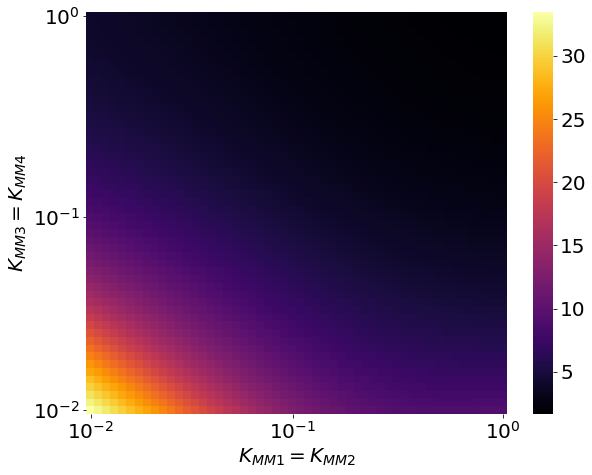

In [19]:
plt.figure(figsize=(9,7))
ax= sb.heatmap(nO_temp_log, cmap='inferno')
plt.xlabel('$K_{MM1}=K_{MM2}$')
plt.ylabel('$K_{MM3}=K_{MM4}$')
ax.invert_yaxis()
plt.xticks([0.5,25.5,51.5], [ '$10^{-2}$', '$10^{-1}$', '$10^{0}$'], rotation=0)
plt.yticks([0.5,25.5,51.5], [ '$10^{-2}$', '$10^{-1}$', '$10^{0}$'], rotation=360)
plt.tight_layout()
plt.show()